# Binary Classification with a Software Defects Dataset


## 0) Intro -  Objective 


Main Goal: Predict defects in C programs given various various attributes about the code.

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## 1) Import of packages

In [257]:
import numpy as np # linear algebra
import optuna
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import ElasticNet,SGDRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)


import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option('display.max_rows', None)

#!pip install -U seaborn

data/test.csv
data/train.csv


## 1) Load the data and check structure

In [258]:
train_data = pd.read_csv("data/train.csv", index_col='id')
test_data = pd.read_csv("data/test.csv", index_col='id')

In [259]:
train_data.head()


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [260]:
train_data.shape

(101763, 22)

#### All numerical variables

In [261]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  un

As explained in the original data :https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction
Number of attributes: 22 (5 different lines of code measure,
3 McCabe metrics, 4 base Halstead measures, 8 derived
Halstead measures, a branch-count, and 1 goal field)

Attribute Information:
  1. loc             : numeric % McCabe's line count of code
  2. v(g)            : numeric % McCabe "cyclomatic complexity"
  3. ev(g)           : numeric % McCabe "essential complexity"
  4. iv(g)           : numeric % McCabe "design complexity"
  5. n               : numeric % Halstead total operators + operands
  6. v               : numeric % Halstead "volume"
  7. l               : numeric % Halstead "program length"
  8. d               : numeric % Halstead "difficulty"
  9. i               : numeric % Halstead "intelligence"
 10. e               : numeric % Halstead "effort"
 11. b               : numeric % Halstead 
 12. t               : numeric % Halstead's time estimator
 13. lOCode          : numeric % Halstead's line count
 14. lOComment       : numeric % Halstead's count of lines of comments
 15. lOBlank         : numeric % Halstead's count of blank lines
 16. lOCodeAndComment: numeric
 17. uniq_Op         : numeric % unique operators
 18. uniq_Opnd       : numeric % unique operands
 19. total_Op        : numeric % total operators
 20. total_Opnd      : numeric % total operands
 21: branchCount     : numeric % of the flow graph
 22. defects         : {false,true} % module has/has not one or more  reported defects


## 3) Discover and visualize data to gain insights

##### No missing data

In [262]:
train_data.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [263]:
test_data.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
dtype: int64

In [264]:
train_data.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,2.085359e+04,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,1.905714e+05,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,5.647300e+02,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,2.256230e+03,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,1.019324e+04,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


#### Defects are not balanced across observatiosn

In [266]:
train_data.defects.value_counts()

False    78699
True     23064
Name: defects, dtype: int64

In [267]:
negative_def = 78699/(78699+23064)
positive_def = 1 - negative_def
class_weights = {0: negative_def, 1: positive_def}
class_weights

{0: 0.7733557383331859, 1: 0.22664426166681406}

### Plot features distribution

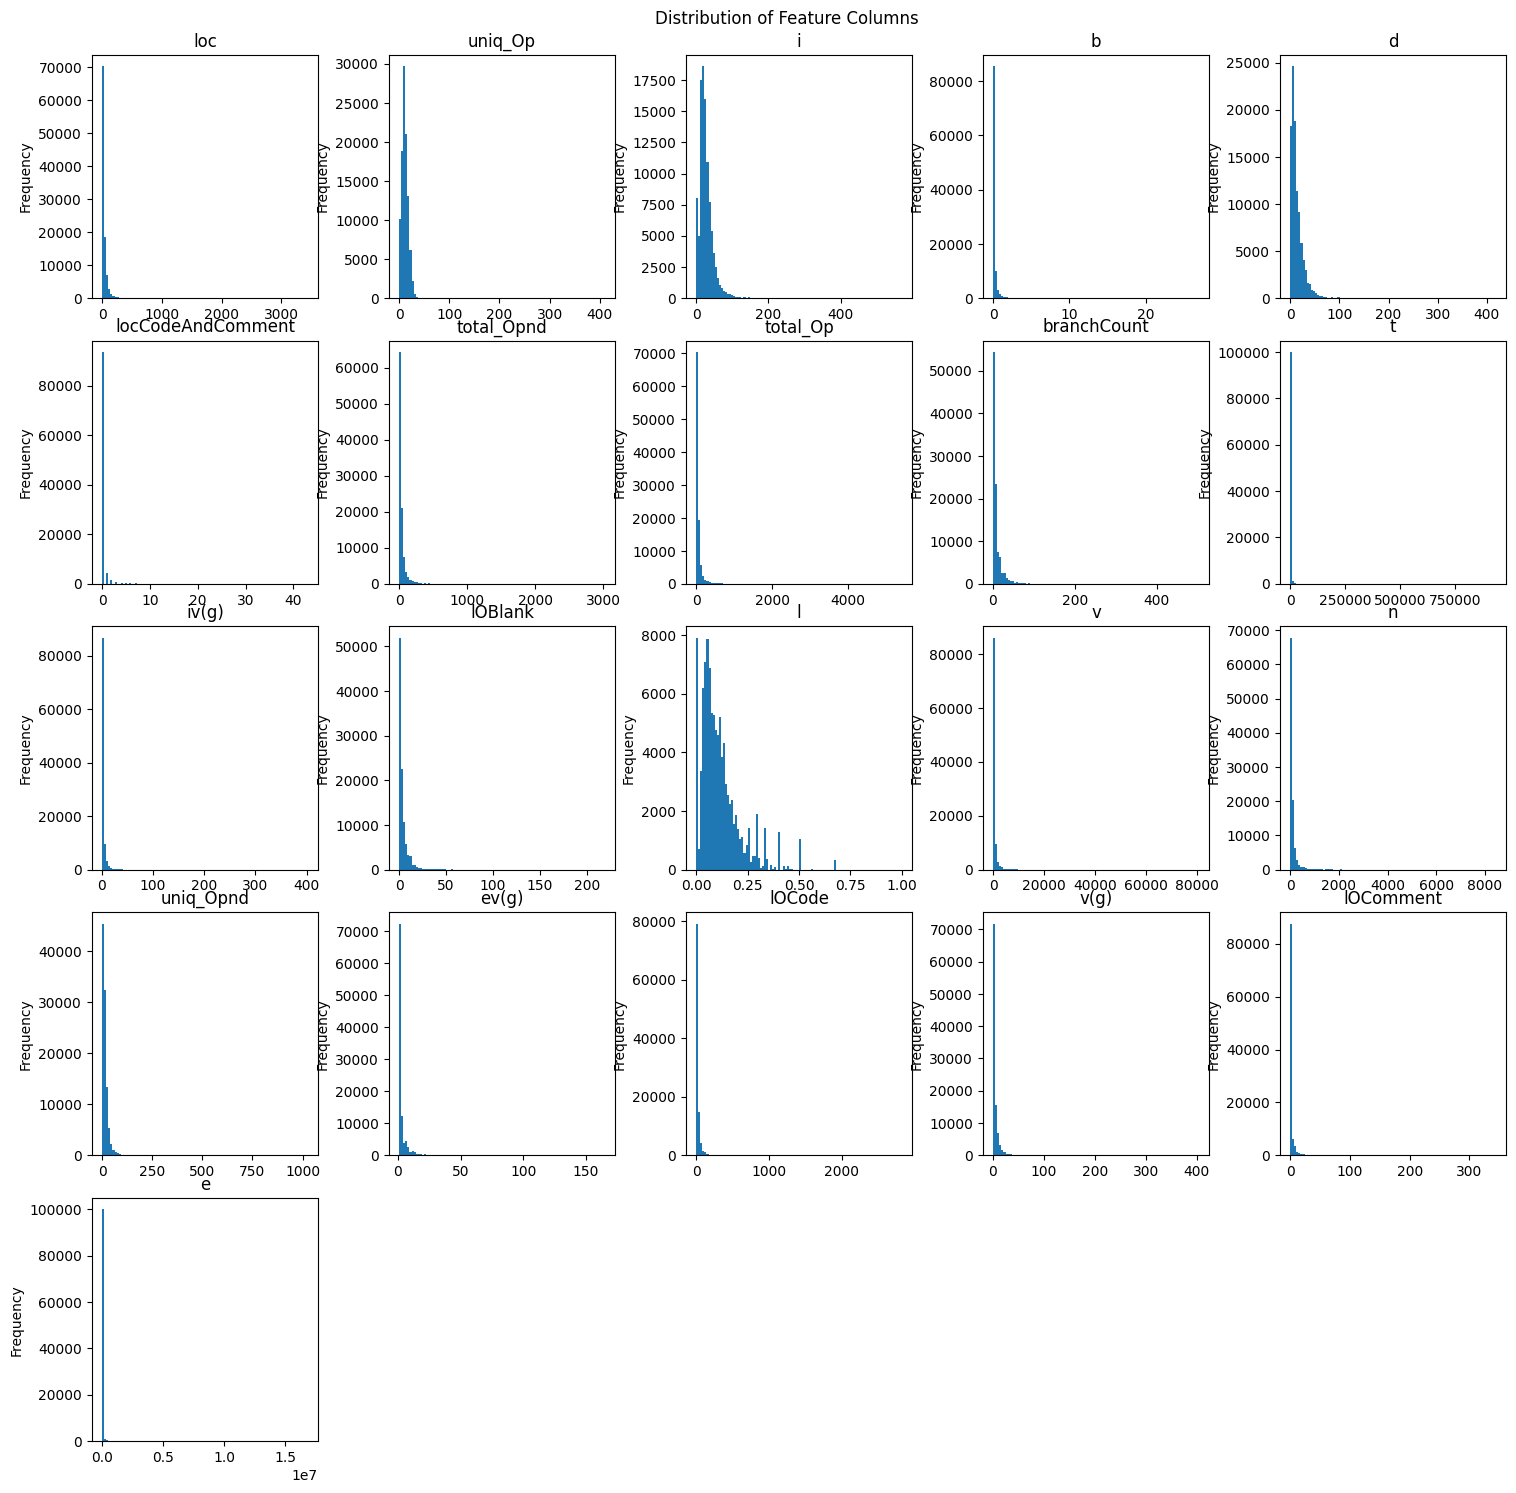

In [268]:
def plot_features_distribution(df):

    feature_columns = set(df.columns)-set(["defects"])

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 4) // 5
    num_cols = min(len(feature_columns), 5)

    # Create subplots
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        df[col].plot(kind='hist', ax=ax, bins=100, title=col)
        ax.set_ylabel('Frequency')

    # If there are empty subplots, remove them
    for i in range(len(feature_columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    # Add a title to the overall picture
    plt.suptitle("Distribution of Feature Columns")
    # Show the plot
    plt.show()



plot_features_distribution(train_data)


### Correlations

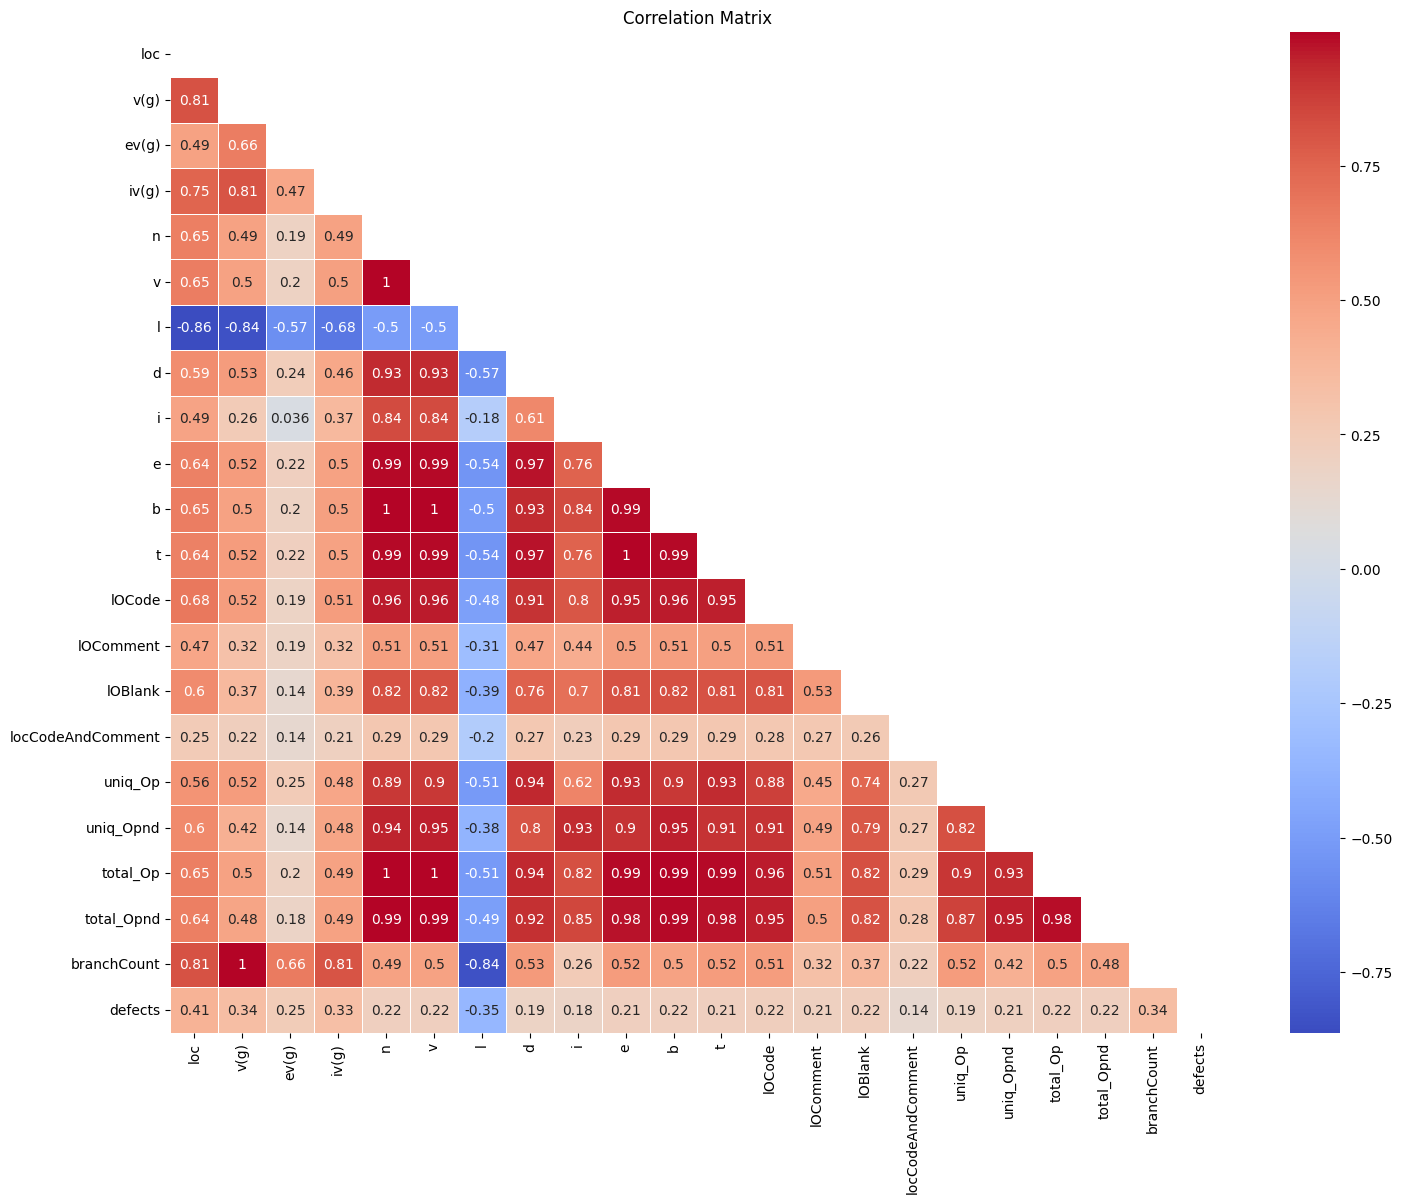

In [269]:
#### Correlation matrix

correlation_matrix = train_data.corr(method="spearman") # To capture non linear correlations
plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


#Relationship: t = e / 18. In the original data, the correlation is perfect. => we can drop t
#Relationship: l = 1 / d => we can drop l

### Observations
- v(g) and branchCount are perfectly correlated
- n is perfectly correlated with v
- b is perfectly correlated with n and v
- e is perfectly correlated with t
- total_Op is perfectly correlated with n and v
- Several variables are highlihly correlated among them
- Variables are very skewed, log transformation should be useful to make better predictions


## Feature engineering

In [270]:
FEATURES = list(set(train_data.columns)-set(["defects"])-set(["t", "l"])) #, "branchCount", "total_Opnd", "b"])) #set(["t", "l", "b"]))
TARGET = 'defects'  

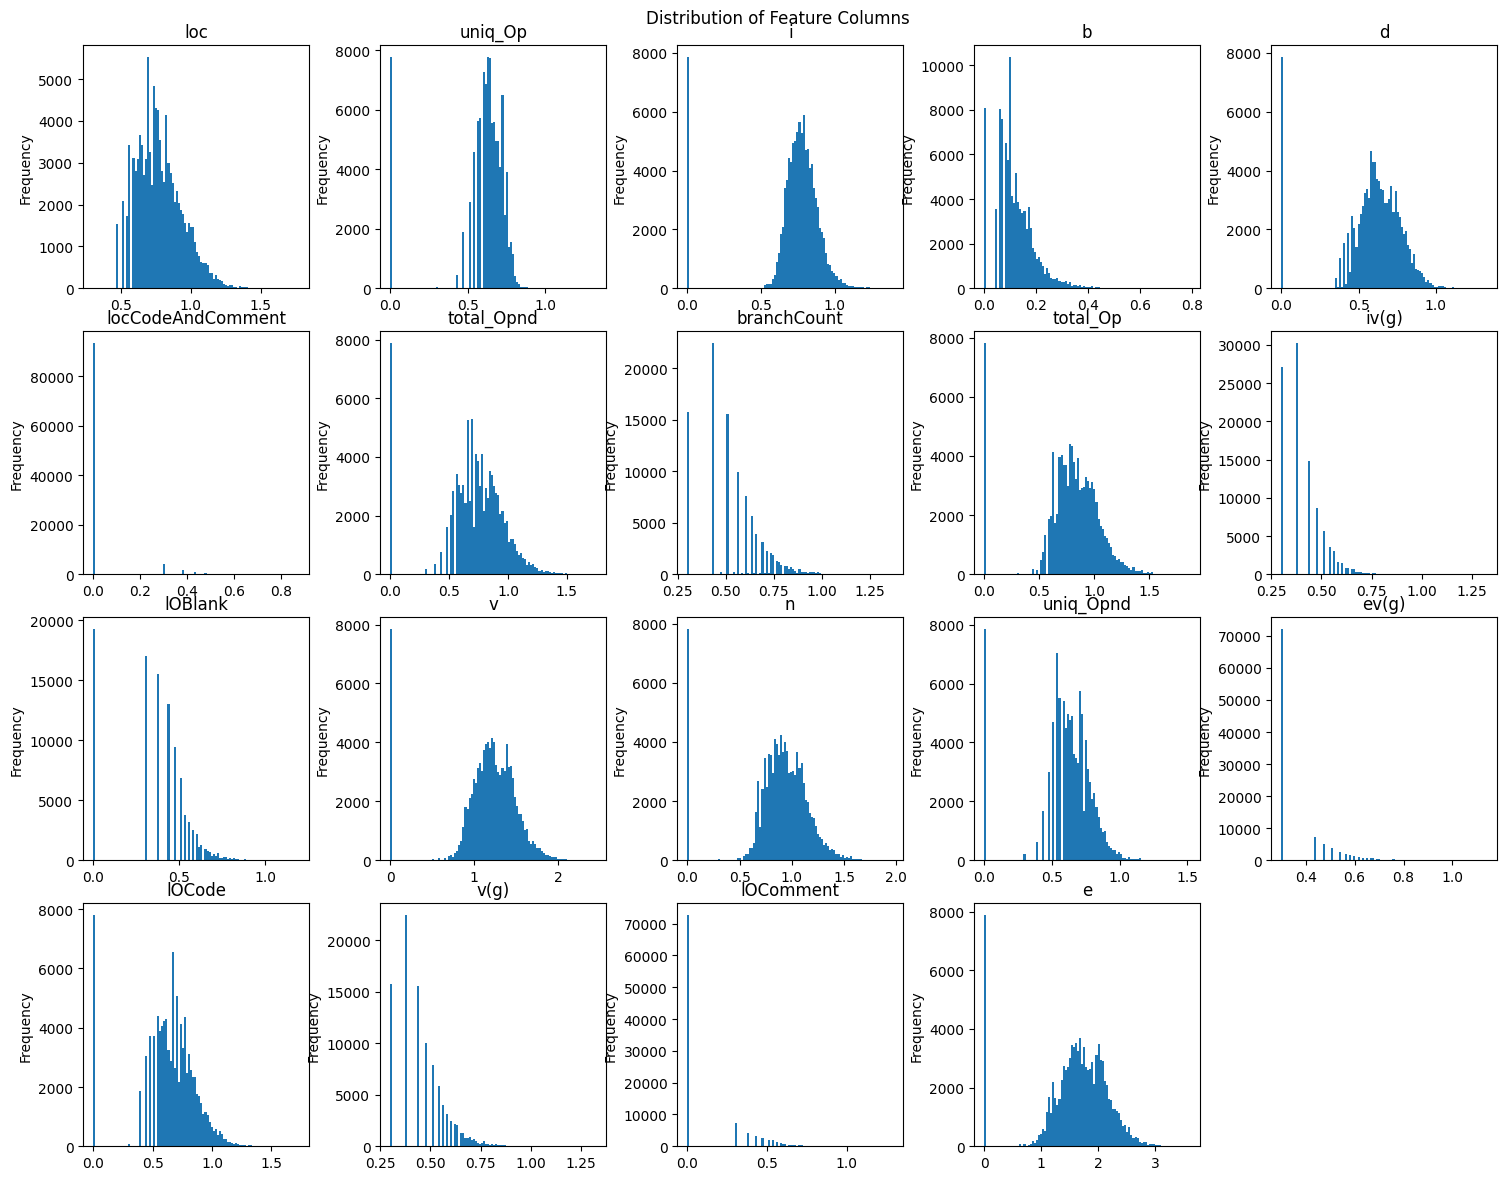

In [271]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

def edit_X_features(df):
    
    df_new = df.copy()

    # df_new["vocabulary_mu"] = df_new.uniq_Op+df_new.uniq_Opnd
    # df_new["v(g)/loc"] = df_new["v(g)"]/df_new["loc"]
    # df_new["iv(g)/loc"] = df_new["iv(g)"]/df_new["loc"]
    # df_new["ev(g)/loc"] = df_new["ev(g)"]/df_new["loc"]

    # df_new['mean_bnv']         = (df_new['n'] + df['v'] + df_new['b']) /3
    # df_new['mean_uniqOpOpend'] = (df_new['uniq_Op'] + df_new['uniq_Opnd']) /2
    # df_new['mean_totOpOpend']  = (df_new['total_Op'] + df_new['total_Opnd']) /2
    # df_new['mean_brcntvg']     = (df_new['branchCount'] + df_new['v(g)']) / 2

    # df_new['loc_50']=(df_new['loc']<50)
    # df_new['n_129']=(df_new['n']<129)
    # df_new['v_755']=(df_new['v']<755)
    # df_new['d_16']=(df_new['d']<16)
    # df_new['i_31']=(df_new['i']<31)
    # df_new['e_35775']=(df_new['e']<35775)
    # # df_new['t_1955']=(df_new['t']<1955)
    # df_new['lOCode_30']=(df_new['lOCode']<30)
    # df_new['uniq_Opnd_19']=(df_new['uniq_Opnd']<19)
    # df_new['total_Op_77']=(df_new['total_Op']<77)
    # df_new['total_Opnd_52']=(df_new['total_Opnd']<52)
    # df_new['branchCount_13']=(df_new['branchCount']<13)
    # # df_new['total_defects']=df_new['loc_50']+df_new['n_129']+df_new['v_755']+df_new['d_16']+df_new['i_31']+df_new['e_35775']+df_new['t_1955']+df_new['lOCode_30']+df_new['uniq_Opnd_19']+df_new['total_Op_77']+df_new['total_Opnd_52']+df_new['branchCount_13']
    # df_new['total_defects']=df_new['loc_50']+df_new['n_129']+df_new['v_755']+df_new['d_16']+df_new['i_31']+df_new['e_35775']+df_new['lOCode_30']+df_new['uniq_Opnd_19']+df_new['total_Op_77']+df_new['total_Opnd_52']+df_new['branchCount_13']

    sqrt_df = np.sqrt(df_new)
    log_df =  np.log10(sqrt_df+1)

    # scaler = MinMaxScaler()
    # scaled_data = scaler.fit_transform(log_df)
    # scaled_df = pd.DataFrame(scaled_data, columns=log_df.columns,  index=df.index)

    return log_df

full_enhanced=  edit_X_features(train_data[FEATURES])
plot_features_distribution(full_enhanced)


### There seems to be several outliers in the distributions

In [272]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

def edit_X_remove_outliers(df, columns):

    print("before", df.shape)
    
    df_new = df.copy()

    for column in columns:
        median = df_new[column].median()
        df_new[column] = df_new[column].replace(0, median)

    print("after", df_new.shape)

    return df_new

# full_enhanced=  edit_X_features(train_data[FEATURES])
# full_enhanced_cleaned=  edit_X_remove_outliers(full_enhanced, ['e', 'uniq_Opnd', 'total_Op', 'uniq_Op', 'v', 'n', 'd', 'total_Opnd'])
# plot_features_distribution(full_enhanced_cleaned)


## Modelling
Split the data into train and validation set, stratify since dataset is unbalanced

In [273]:
y = train_data.copy().defects.astype(int)

# X = train_data.copy()[FEATURES]
X = edit_X_features(train_data.copy()[FEATURES])
# X = edit_X_remove_outliers(X, ['e', 'uniq_Opnd', 'total_Op', 'uniq_Op', 'v', 'n', 'd'])

# Single split
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)

### Cross validation strategy

In [274]:
kfold = KFold(n_splits=5,shuffle=True,random_state=0)
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

### Simple logistic regression

In [275]:
from sklearn.linear_model import LogisticRegression

def logistic_predictions(train_X, train_y):

    reg = LogisticRegression()
    
    reg.fit(train_X,train_y)
    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    return predictions, reg

log_predictions_val, log_model = logistic_predictions(train_X, train_y)

ROC-AUC score training 0.7846244589008644
ROC-AUC score validation 0.7859513805009779


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### XGB Classifier

#### Single execution

In [276]:
xgb_params = {'objective':'binary:logistic', 
              'n_estimators':1000,
              'learning_rate':0.03858856691681774,
              'max_depth':None,
              'gamma':14,
              'scale_pos_weight':negative_def/positive_def,
              'random_state':0}

def XGBoost_predictions(train_X, train_y, val_X, val_y, xgb_params):

    reg = xgb.XGBClassifier(eval_metric  = "mape", **xgb_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

xgb_predictions_val, xgb_model, xgb_val_auc = XGBoost_predictions(train_X, train_y,val_X, val_y, xgb_params)

#xgb_model.score

ROC-AUC score training 0.8042399758367711
ROC-AUC score validation 0.7940467909114792


#### Parameter optimization

In [ ]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def xgb_objective(trial):

        # Set the hyperparameters of the XGBoost classifier.
        params = {'objective':'binary:logistic', 
                  'n_estimators':120,
                  'learning_rate':0.03858856691681774, #trial.suggest_float('learning_rate',0.03,0.3)
                  'max_depth':None,
                  'gamma':trial.suggest_int('gamma',0,15),
                  'scale_pos_weight':77.3/22.7,
                  'random_state':0
                 }

        xgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            xgb_auc_score_avg += xgb_val_auc_fold
            
        xgb_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using XGB model:', xgb_auc_score_avg)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_objective, n_trials=10)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGB hyper parameters:', best_xgb_params)

### Random forest classifier

#### Single execution

In [277]:
rf_params = { 'n_estimators':935,
              'max_depth':10,
              'min_samples_split':3,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':True,
              'n_jobs' :-1}

# rf_params = { 'n_estimators':338,
#               'max_depth':9,
#               'min_samples_split':3,
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':True,
#               'n_jobs' :-1}

def RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params):

    reg = RandomForestClassifier(**rf_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

random_forest_predictions_val, rf_model, rf_val_auc = RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params)

ROC-AUC score training 0.8127539517133179
ROC-AUC score validation 0.7907051573328838


#### Parameter optimization

In [ ]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def rf_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}
        params = {'n_estimators':trial.suggest_int('n_estimators',200,1000),
              'max_depth':10,
              'min_samples_split':3,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':True,
              'n_jobs' :-1}

        rf_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            rf_auc_score_avg += rf_val_auc_fold
            
        rf_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -rf_auc_score_avg

    rf_study = optuna.create_study()
    rf_study.optimize(rf_objective, n_trials=20)
    best_rf_params = rf_study.best_trial.params

    print('Best RF hyper parameters:', best_rf_params)

In [ ]:
# optuna.visualization.plot_contour(rf_study)
# optuna.visualization.plot_param_importances(rf_study)

### ExtraTreesClassifier

#### Single Execution


In [278]:
et_params = { 'n_estimators':549,
              'max_depth':16,
              'max_features':'auto',
              'min_samples_split':9,
              'min_samples_leaf':3,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}

def ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params):

    reg = ExtraTreesClassifier(**et_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

extratree_classifier_predictions_val, extratree_model, etrateree_val_auc = ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params)

ROC-AUC score training 0.8380272004846685
ROC-AUC score validation 0.7888086036145446


#### Parameters optimization

In [ ]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def extratree_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}
        params = {'n_estimators':trial.suggest_int('n_estimators',100,1000),
              'max_depth':trial.suggest_int('max_depth',1,100),
              'max_features':'auto',
              'min_samples_split':trial.suggest_int('min_samples_split',2,10),
              'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10),
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}
        
        et_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            et_predictions_fold, et_model_fold, et_val_auc_fold = extratree_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            et_auc_score_avg += et_val_auc_fold
            
        et_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -et_auc_score_avg

    et_study = optuna.create_study()
    et_study.optimize(extratree_objective, n_trials=100)
    best_et_params = et_study.best_trial.params

    print('Best Extratree hyper parameters:', best_et_params)

In [ ]:
# optuna.visualization.plot_contour(et_study)
# optuna.visualization.plot_param_importances(et_study)


### Logistic regression with Nyström kernel approximation

#### Single Execution

In [279]:
nystroem_params = {'n_components':384}

def nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params):

    # Standardize the features (optional but recommended)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_X)
    X_test = scaler.transform(val_X)

    # Create a Nystroem feature map
    nystroem = Nystroem(kernel='rbf', **nystroem_params, random_state=42)

    # Apply the feature map to both the training and testing data
    X_train_nystroem = nystroem.fit_transform(X_train)
    X_test_nystroem = nystroem.transform(X_test)

    # Create and train the logistic regression model
    reg = LogisticRegression()
    reg.fit(X_train_nystroem, train_y)

    # Make predictions on the test set
    predictions_train = reg.predict_proba(X_train_nystroem)[:,1]

    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(X_test_nystroem)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

nystroem_logistic_predictions_val, nystroem_logistic_model, nystroem_val_auc_fold = nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params)

ROC-AUC score training 0.792831430797518
ROC-AUC score validation 0.79427310615887


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Parameters optimization

In [ ]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def nystroem_objective(trial):
        params = {'n_components':trial.suggest_int('n_components',50,500)}        
        
        ny_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, params)
            ny_auc_score_avg += ny_val_auc_fold
            
        ny_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -ny_auc_score_avg

    ny_study = optuna.create_study()
    ny_study.optimize(nystroem_objective, n_trials=30)
    best_ny_params = ny_study.best_trial.params

    print('Best nystroem logistic hyper parameters:', best_ny_params)

### CatBoostClassifier

#### Single Execution

In [280]:
cb_params = { 'iterations':938,
              'depth':4,
              'learning_rate':0.06903134415479134,
              'l2_leaf_reg':7,
              'loss_function':'Logloss',
              'verbose':0,
              'random_seed':42,
              'class_weights':class_weights
              }

# cb_params = { 'iterations':1990,
#               'depth':5,
#               'learning_rate':0.04418143696140913,
#               'l2_leaf_reg':9,
#               'loss_function':'Logloss',
#               'verbose':0,
#               'random_seed':42,
#               'class_weights':class_weights
#               }

def CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params):

    reg = CatBoostClassifier(**cb_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

catbost_classifier_predictions_val, catboost_model, catboost_val_auc = CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params)

ROC-AUC score training 0.7995676238212321
ROC-AUC score validation 0.7931529035161206


#### Parameters optimization


In [ ]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def catboost_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}    

        params = {'iterations':trial.suggest_int('iterations',500, 2000),
              'depth':trial.suggest_int('depth',1,10),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',1,10),
              'loss_function':'Logloss',
              'verbose':0,
              'random_seed':42,
              'class_weights':class_weights
              }
        
        cb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            cb_auc_score_avg += cb_val_auc_fold
            
        cb_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -cb_auc_score_avg

    cb_study = optuna.create_study()
    cb_study.optimize(catboost_objective, n_trials=10)
    best_cb_params = cb_study.best_trial.params

    print('Best catboost hyper parameters:', best_cb_params)

### LGBMClassifier

#### Single Execution

In [281]:
lgbm_params = { 'boosting_type':'gbdt',
              'num_leaves':17,
              'learning_rate':0.013240041792690652,
              'n_estimators':431,
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }

def lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params):

    reg = lgb.LGBMClassifier(**lgbm_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

lgbm_classifier_predictions_val, lgbm_model, lgbm_val_auc= lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params)

ROC-AUC score training 0.7988682457016714
ROC-AUC score validation 0.7934173326966324


#### Parameters optimization

In [ ]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def lgbm_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}    
     
        params = { 'boosting_type':'gbdt',
              'num_leaves':trial.suggest_int('num_leaves',10, 200),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'n_estimators':trial.suggest_int('n_estimators',100, 2000),
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }
        
        lgbm_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            lgbm_predictions_fold, lgbm_model_fold, lgbm_val_auc_fold = lgbm_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            lgbm_auc_score_avg += lgbm_val_auc_fold
            
        lgbm_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -lgbm_auc_score_avg

    lgbm_study = optuna.create_study()
    lgbm_study.optimize(lgbm_objective, n_trials=100)
    best_lgbm_params = lgbm_study.best_trial.params

    print('Best lgbm hyper parameters:', best_lgbm_params)

### HistGradientBoostingClassifier

#### Single Execution

In [282]:
hgbc_params =  {'max_iter': 477, 
                'learning_rate': 0.04584446359126259, 
                'max_depth': 3, 
                'l2_regularization': 0.0822627761827129, 
                'random_state':42,}

def hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params):

    reg = HistGradientBoostingClassifier(**hgbc_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    return predictions, reg, val_auc

hgbc_classifier_predictions_val, hgbc_model, hgbc_val_auc = hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params)

ROC-AUC score training 0.7956344796065649
ROC-AUC score validation 0.7942280248665874


#### Parameter optimization

In [283]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def hgbc_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
        class_weights = {0: 0.773, 1: 0.227}    
           
        params = {
            'max_iter':trial.suggest_int('max_iter',1, 1000),
            'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
            'max_depth':trial.suggest_int('max_depth',1, 100),
            'random_state':42,
            'l2_regularization':trial.suggest_float('l2_regularization',0, 0.1),
              }
        
        hgbc_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params)
            hgbc_auc_score_avg += hgbc_val_auc_fold
            
        hgbc_auc_score_avg /=5
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -hgbc_auc_score_avg

    hgbc_study = optuna.create_study()
    hgbc_study.optimize(hgbc_objective, n_trials=100)
    best_hgbc_params = hgbc_study.best_trial.params

    print('Best hgbc hyper parameters:', best_hgbc_params)

## Check AUC-ROC

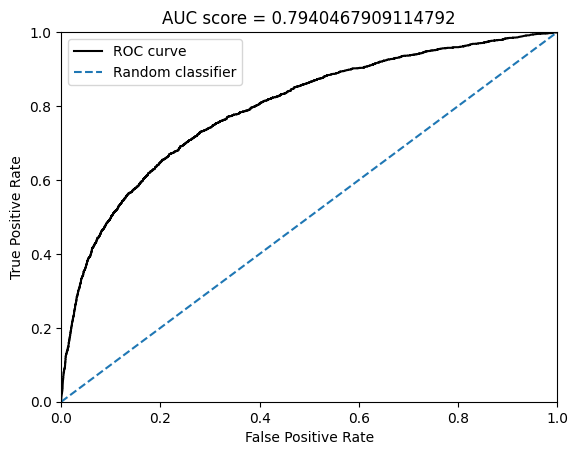

In [284]:
def plot_roc(val_y,pred_y):
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(val_y,pred_y, pos_label=1)

    plt.plot(fpr, tpr, 'k', label='ROC curve')

    # Plot the baseline
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

    # Set the axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set axis limits
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Set the title
    plt.title('AUC score = ' + str(roc_auc_score(val_y,pred_y)))

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()
    
plot_roc(val_y,xgb_predictions_val)
# plot_roc(val_y,random_forest_predictions)
# plot_roc(val_y,extratree_classifier_predictions)
# plot_roc(val_y,log_predictions)

### Rank models by performance

In [285]:
val_predictions_roc = {'xgb':roc_auc_score(val_y,xgb_predictions_val),
                       'rf':roc_auc_score(val_y,random_forest_predictions_val),
                       'extratree':roc_auc_score(val_y,extratree_classifier_predictions_val),
                       'log':roc_auc_score(val_y,log_predictions_val),
                       'lgbm':roc_auc_score(val_y,lgbm_classifier_predictions_val),
                       'catboost':roc_auc_score(val_y,catbost_classifier_predictions_val),
                       'hgbc':roc_auc_score(val_y,hgbc_classifier_predictions_val),
                       'nystroem':roc_auc_score(val_y,nystroem_logistic_predictions_val),                      
                       }

val_predictions_roc = sorted(val_predictions_roc.items(), key=lambda x:x[1],  reverse=True)
val_predictions_roc


[('nystroem', 0.79427310615887),
 ('hgbc', 0.7942280248665874),
 ('xgb', 0.7940467909114792),
 ('lgbm', 0.7934173326966324),
 ('catboost', 0.7931529035161206),
 ('rf', 0.7907051573328838),
 ('extratree', 0.7888086036145446),
 ('log', 0.7859513805009779)]

### Optimize weights for the ensamble with Optuna (on initial validation set)

In [286]:
ensamble_weights = [10, 12, 40, 38, 0, 0, 0] #[0.20, 0.15, 0.20, 0.15, 0.20, 0.05, 0.05] ## manual version
model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val, hgbc_classifier_predictions_val, lgbm_classifier_predictions_val, random_forest_predictions_val, extratree_classifier_predictions_val]

ensamble_predictions_val = np.average(model_predictions_val, weights=ensamble_weights, axis=0)
roc_auc_score(val_y,ensamble_predictions_val)

0.7951546836350778

In [ ]:
0.795142786800462
0.7950905178372656
0.7950905178372656
0.7951546836350778


0.7950905178372656

In [289]:
if True:
  def ensamble_objective(trial):
    STEP_SIZE = 1

    weights = []
    all_models_predictions = []

    # we'll use a variable for setting upper limit for suggested value
    # since we intend to update it after each weight suggestion
    upper_limit = 100

    w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_xgb)

    upper_limit -= w_xgb
    upper_limit = upper_limit

    w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_catboost)

    upper_limit -= w_catboost
    upper_limit = upper_limit

    w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_nystroem)

    upper_limit -= w_nystroem
    upper_limit = upper_limit

    w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_hgbc)

    upper_limit -= w_hgbc
    upper_limit = upper_limit

    w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_lgbm)

    upper_limit -= w_lgbm
    upper_limit = upper_limit

    w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_rf)

    # w_extratree = 100 - sum(weights)
    # weights.append(w_extratree)

    w_extratree = trial.suggest_int("w_extratree", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_extratree)

    # Just as a sanity check, we'll check that the sum of all weights is equal to 100
    weights_sum = sum(weights)
    # if weights_sum != 100:
    #   raise Exception(f"Weights sum must be equal to 100. Instead {weights_sum} was encountered!")
    
    model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val, hgbc_classifier_predictions_val, 
                            lgbm_classifier_predictions_val, random_forest_predictions_val, extratree_classifier_predictions_val]

    ensamble_predictions_val = np.average(model_predictions_val, weights=weights, axis=0)
    auroc_ensamble_avg = roc_auc_score(val_y,ensamble_predictions_val)

    return -auroc_ensamble_avg


  ensamble_study = optuna.create_study(study_name="optimizing weights")
  ensamble_study.optimize(ensamble_objective, n_trials=2000, show_progress_bar=True)

  best_ensamble_params = ensamble_study.best_trial.params

  print('Best ensamble weights:', best_ensamble_params)

  best_ensamble_params["w_extratree"]=100-sum(best_ensamble_params.values())

  best_ensamble_params


[I 2023-10-21 16:23:23,291] A new study created in memory with name: optimizing weights


  0%|          | 0/2000 [00:00<?, ?it/s]

[I 2023-10-21 16:23:23,307] Trial 0 finished with value: -0.7944959514961646 and parameters: {'w_xgb': 72, 'w_catboost': 14, 'w_nystroem': 13, 'w_hgbc': 0, 'w_lgbm': 1, 'w_rf': 0, 'w_extratree': 0}. Best is trial 0 with value: -0.7944959514961646.
[I 2023-10-21 16:23:23,313] Trial 1 finished with value: -0.7942646241564125 and parameters: {'w_xgb': 82, 'w_catboost': 3, 'w_nystroem': 6, 'w_hgbc': 0, 'w_lgbm': 4, 'w_rf': 1, 'w_extratree': 2}. Best is trial 0 with value: -0.7944959514961646.
[I 2023-10-21 16:23:23,321] Trial 2 finished with value: -0.7944816863102133 and parameters: {'w_xgb': 67, 'w_catboost': 19, 'w_nystroem': 10, 'w_hgbc': 2, 'w_lgbm': 0, 'w_rf': 0, 'w_extratree': 1}. Best is trial 0 with value: -0.7944959514961646.
[I 2023-10-21 16:23:23,329] Trial 3 finished with value: -0.7943286247204105 and parameters: {'w_xgb': 80, 'w_catboost': 5, 'w_nystroem': 5, 'w_hgbc': 9, 'w_lgbm': 0, 'w_rf': 1, 'w_extratree': 0}. Best is trial 0 with value: -0.7944959514961646.
[I 2023-10-2

In [290]:
best_ensamble_params

{'w_xgb': 13,
 'w_catboost': 16,
 'w_nystroem': 35,
 'w_hgbc': 30,
 'w_lgbm': 0,
 'w_rf': 0,
 'w_extratree': 6}

In [ ]:
best_ensamble_params = {'w_xgb': 21,
 'w_catboost': 35,
 'w_nystroem': 33,
 'w_hgbc': 11,
 'w_lgbm': 0,
 'w_rf': 0,
 'w_extratree': 0}

{'w_xgb': 21,
 'w_catboost': 35,
 'w_nystroem': 33,
 'w_hgbc': 11,
 'w_lgbm': 0,
 'w_rf': 0,
 'w_extratree': 0}

## Final Prediction for test set

In [291]:
X_test = test_data.copy()
X_test = X_test[FEATURES]
X_test = edit_X_features(X_test)

xgb_predictions = xgb_model.predict_proba(X_test)[:,1]
random_forest_predictions = rf_model.predict_proba(X_test)[:,1]
extratree_classifier_predictions = extratree_model.predict_proba(X_test)[:,1]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_X.copy())
X_test_scaled = scaler.transform(X_test.copy())
n_components = nystroem_params["n_components"] 
nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)
X_train_nystroem = nystroem.fit_transform(X_train_scaled)
X_test_nystroem = nystroem.transform(X_test_scaled)
nystroem_logistic_predictions = nystroem_logistic_model.predict_proba(X_test_nystroem)[:,1]

catbost_classifier_predictions = catboost_model.predict_proba(X_test)[:,1]
lgbm_classifier_predictions = lgbm_model.predict_proba(X_test)[:,1]
hgbc_classifier_predictions = hgbc_model.predict_proba(X_test)[:,1]


# final_prediction = 0.20 * xgb_predictions + \
#                    0.15 * catbost_classifier_predictions + \
#                    0.20 * nystroem_logistic_predictions + \
#                    0.15 * hgbc_classifier_predictions + \
#                    0.20 * lgbm_classifier_predictions + \
#                    0.05 * random_forest_predictions + \
#                    0.05 * extratree_classifier_predictions

#final_prediction = lgbm_classifier_predictions

model_predictions_test = [xgb_predictions, catbost_classifier_predictions, nystroem_logistic_predictions, hgbc_classifier_predictions, lgbm_classifier_predictions, random_forest_predictions, extratree_classifier_predictions]

final_prediction = np.average(model_predictions_test, weights=list(best_ensamble_params.values()), axis=0)


# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, 'defects':final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,defects
id,
101763,0.241078
101764,0.198340
101765,0.625438


### Voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
X_test = test_data.copy()
X_test = X_test[FEATURES]
X_test = edit_X_features(X_test)

voting_models = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    # ('ny', nystroem_logistic_model),
    ('et', extratree_model),
    ('cb', catboost_model),
    ('lgbm', lgbm_model),
    ('hgbc', hgbc_model),
],
voting='soft',
# weights=[0.20, 0.05, 0.20, 0.05, 0.15, 0.20, 0.15])
weights=[0.30, 0.05, 0.05, 0.15, 0.20, 0.25])

voting_models.fit(train_X, train_y)
final_prediction = voting_models.predict_proba(X_test)[:,1]


# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, 'defects':final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,defects
id,
101763,0.241426
101764,0.212227
101765,0.588443


### Voting classifier trained on the full train dataset

In [ ]:
from sklearn.ensemble import VotingClassifier
X_test = test_data.copy()
X_test = X_test[FEATURES]
X_test = edit_X_features(X_test)

voting_models = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('rf', rf_model),
    # ('ny', nystroem_logistic_model),
    ('et', extratree_model),
    ('cb', catboost_model),
    ('lgbm', lgbm_model),
    ('hgbc', hgbc_model),
],
voting='soft',
# weights=[0.20, 0.05, 0.20, 0.05, 0.15, 0.20, 0.15])
weights=[0.30, 0.05, 0.05, 0.15, 0.20, 0.25])

voting_models.fit(X, y)
final_prediction = voting_models.predict_proba(X_test)[:,1]


# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, 'defects':final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,defects
id,
101763,0.253774
101764,0.206452
101765,0.592394


### Submit predictions

In [292]:
submission.to_csv('submissions/44.ensamble_with_transf_XGB_RF_ET_CB_LB_HGBC_optuna_weights_specific_classweights.csv')

### Optimize ensambling with Optuna

In [ ]:
def ensamble_objective(trial):
  STEP_SIZE = 5

  weights = []
  all_models_predictions = []

  # we'll use a variable for setting upper limit for suggested value
  # since we intend to update it after each weight suggestion
  upper_limit = 100

  w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_xgb)

  upper_limit -= w_xgb
  upper_limit = upper_limit

  w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_catboost)

  upper_limit -= w_catboost
  upper_limit = upper_limit

  w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_nystroem)

  upper_limit -= w_nystroem
  upper_limit = upper_limit

  w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_hgbc)

  upper_limit -= w_hgbc
  upper_limit = upper_limit

  w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_lgbm)

  upper_limit -= w_lgbm
  upper_limit = upper_limit

  w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
  weights.append(w_rf)

  w_extratree = 100 - sum(weights)
  weights.append(w_extratree)

  # Just as a sanity check, we'll check that the sum of all weights is equal to 100
  weights_sum = sum(weights)
  if weights_sum != 100:
    raise Exception(f"Weights sum must be equal to 100. Instead {weights_sum} was encountered!")
  
  auroc_ensamble_avg = 0
  for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

      print("Running fold ", idx)
      train_X_fold = X.iloc[train_idx]
      val_X_fold = X.iloc[val_idx]
      train_y_fold = y[train_idx]
      val_y_fold = y[val_idx]

      # We'll use the default parameter values for all our models  

      xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, xgb_params)
      all_models_predictions.append(xgb_predictions_fold)

      ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, nystroem_params)
      all_models_predictions.append(ny_predictions_fold)

      rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, rf_params)
      all_models_predictions.append(rf_predictions_fold)
      
      cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, cb_params)
      all_models_predictions.append(cb_predictions_fold)

      lgbm_predictions_fold, lgbm_model_fold, lgbm_val_auc_fold = lgbm_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, lgbm_params)
      all_models_predictions.append(lgbm_predictions_fold)
   
      et_predictions_fold, et_model_fold, et_val_auc_fold = ExtraTrees_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, et_params)
      all_models_predictions.append(et_predictions_fold)

      hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, hgbc_params)
      all_models_predictions.append(hgbc_predictions_fold)

      # let's take the weighted average of the predictions using numpy
      y_pred_final_fold = np.average(all_models_predictions, weights=weights, axis=0)
      # computing our metric i.e. MSE
      auroc_ensamble_fold = roc_auc_score(val_y_fold, y_pred_final_fold)
      auroc_ensamble_avg += auroc_ensamble_fold

      all_models_predictions = []

  auroc_ensamble_avg /=5

  return -auroc_ensamble_avg

In [ ]:
ensamble_study = optuna.create_study(study_name="optimizing weights")
ensamble_study.optimize(ensamble_objective, n_trials=100)

best_ensamble_params = ensamble_study.best_trial.params

print('Best ensamble weights:', best_ensamble_params)

[I 2023-10-20 23:46:23,448] A new study created in memory with name: optimizing weights
[I 2023-10-20 23:46:23,455] Trial 0 finished with value: -0.7942109782447653 and parameters: {'w_xgb': 67, 'w_catboost': 31, 'w_nystroem': 2, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 0 with value: -0.7942109782447653.
[I 2023-10-20 23:46:23,460] Trial 1 finished with value: -0.7940069971012481 and parameters: {'w_xgb': 91, 'w_catboost': 8, 'w_nystroem': 0, 'w_hgbc': 0, 'w_lgbm': 1, 'w_rf': 0}. Best is trial 0 with value: -0.7942109782447653.
[I 2023-10-20 23:46:23,467] Trial 2 finished with value: -0.7942575741803439 and parameters: {'w_xgb': 72, 'w_catboost': 0, 'w_nystroem': 5, 'w_hgbc': 21, 'w_lgbm': 2, 'w_rf': 0}. Best is trial 2 with value: -0.7942575741803439.
[I 2023-10-20 23:46:23,471] Trial 3 finished with value: -0.7939281530329493 and parameters: {'w_xgb': 99, 'w_catboost': 1, 'w_nystroem': 0, 'w_hgbc': 0, 'w_lgbm': 0, 'w_rf': 0}. Best is trial 2 with value: -0.7942575741803439

Best ensamble weights: {'w_xgb': 14, 'w_catboost': 21, 'w_nystroem': 48, 'w_hgbc': 13, 'w_lgbm': 3, 'w_rf': 1}


In [ ]:
# optuna.visualization.plot_contour(ensamble_study)
# optuna.visualization.plot_param_importances(rf_study)

In [ ]:
### Considetations
- Adding new enegineered variables always worsen the performance of the models

SyntaxError: invalid syntax (1669986422.py, line 2)

## Valuable sources
- https://www.kaggle.com/competitions/playground-series-s3e23/discussion/445245
- https://www.kaggle.com/competitions/playground-series-s3e23/discussion/444685
- https://www.kaggle.com/competitions/playground-series-s3e23/discussion/445536
- https://www.kaggle.com/code/yunsuxiaozi/pss3e23-fusion-model-k-fold (feature engineering)

